 # 3.3 MNIST Handwritten Digits

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.layers import *
from keras.models import Sequential, Model
from keras.optimizers import Adam

## Define Class

In [ ]:
class PPAN:
    def __init__(self, img_size=(28, 28), channels=1, noise_dim=20, learning_rates=[1e-4, 1e-4, 1e-3], utility_weight=2, valid_weight=1):
        '''
        Build PPAN model
        Args:
            img_size: tuple, input image size, default=(28, 28)
            channels: int, input image channels, default=1
            noise_dim: int, noise input of mechanism network, default=20
            learning_rates: list, list of learning rates of adversary, discriminator and mechanism, default=[1e-4, 1e-4, 1e-3]
            utility_weight: float, weight of the utility loss, default=2
            valid_weight: float, weight of the discriminator loss, default=1
        Returns:
            PPAN object
        '''
        # Get variables
        self.img_size = img_size
        self.channels = channels
        self.noise_dim = noise_dim
        # Get networks
        self.mechanism = build_mechanism()
        self.adversary = build_adversary()
        self.discriminator = build_discriminator()
        # Setup optimizers
        a_optimizer = Adam(learning_rate_a, 0.5, clipvalue=0.1)
        d_optimizer = Adam(learning_rate_d, 0.5, clipvalue=0.1)
        m_optimizer = Adam(learning_rate_m, 0.5)
        # Compile discriminators
        self.adversary.compile(loss="categorical_crossentropy", optimizer=a_optimizer, metrics=["accuracy"])
        self.discriminator.compile(loss="binary_crossentropy", loss_weights=self.gama, optimizer=d_optimizer, metrics=["accuracy"])
        # Combined two discriminators with the mechanism(generator)
        original_img = Input(shape=self.img_size[0]*self.img_size[1])
        gen_img = self.mechanism(original_img)
        # Freeze discriminators
        self.adversary.trainable = False
        self.discriminator.trainable = False
        # Get predictions from discriminators
        pred_label = self.adversary(gen_img)
        pred_valid = self.discriminator(gen_img)
        self.ppan = Model(inputs=[gen_img, gen_img], outputs=[pred_label, pred_valid])
        # Compile mechanism
        self.ppan.compile(loss="kullback_leibler_divergence", loss_weights=self.lambda, optimizer=m_optimizer)
        print("=== Model Summary ===")
        self.ppan.summary()
        
    def build_mechanism(self):
        model = Sequential(name="Mechanism")
        
        model.add(Dense(1000, activation="tanh", input_shape=self.img_size[0]*self.img_size[1]+self.noise_dim))
        model.add(Dense(1000, activation="tanh"))
        model.add(Dense(self.img_size[0]*self.img_size[1], activation="sigmoid"))
        
        noised_img = Input(shape=self.img_size[0]*self.img_size[1]+self.noise_dim)
        gen_img = model(x)
        
        return Model(noised_img, gen_img)
    
    def build_adversary(self):
        model = Sequential(name="Adversary")
        
        model.add(Dense(1000, activation="tanh", input_shape=self.img_size[0]*self.img_size[1]))
        model.add(Dense(1000, activation="tanh"))
        model.add(Dense(10, activation="softmax"))
        
        img = Input(shape=self.img_size[0]*self.img_size[1])
        label = model(img)
        
        return Model(img, label)
    
    def build_discriminator(self):
        model = Sequential(name="Discriminator")
        
        model.add(Dense(500, activation="tanh", input_shape=self.img_size[0]*self.img_size[1]))
        model.add(Dense(1, activation="sigmoid"))
        
        img = Input(shape=self.img_size[0]*self.img_size[1])
        pred = model(img)
        
        return Model(img, pred)
    
    def train(self, x_train, y_train, x_test, y_test, epochs, batch_size, save_path, print_interval=10, save_interval=50):
        '''
        Train model
        Args:
            x_train: ndarray, training images
            y_train: ndarray, training labels
            x_test: ndarray, testing images
            y_test: ndarray, testing labels
            epochs: int, training epochs
            batch_size: int, training batch size
            save_path: string, saving path for generated images during training process
            print_interval: int, print accuracy & loss every print_interval epochs, default=10
            save_interval: int, save generated images every save_interval, default=50
        Returns:
            None
        '''
        # Flatten images data
        x_train = x_train.reshape((x_train.shape[0], self.img_size[0]*self.img_size[1]))
        x_train = x_test.reshape((x_test.shape[0], self.img_size[0]*self.img_size[1]))
        # Set labels for discriminator
        valid = np.ones(shape=(batch_size, 1))
        fake = np.zeros(shape=(batch_size, 1))
        # Store training loss and accuracy in an array
        self.losses = np.zeros(shape=(epochs, 3))    # privacy/realistic/utility loss (a/d/m networks)
        self.accuracies = np.zeros(shape=(epochs, 2))    # adversary/discriminator accuracy
        # Training
        for e in range(epochs):
            # Random sample batch_size images from data
            idx = np.random.randint(low=0, high=x_train.shape[0], size=batch_size)
            imgs = x_train[idx]
            # Sample noise and generate a batch of new images
            noise = np.random.uniform(low=-1, high=1, size=(self.batch_size, self.noise_dim))
            gen_imgs = self.mechanism.predict(np.hstack(imgs, noise))
            # Train adversary
            
            # Train discriminator
            # Train mechanism

## Load Data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

/home/sitibanc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


11493376/11490434 [==============================] - 5s 0us/step


## Data Preprocessing

In [25]:
flatten_010 = x_train[0:10].reshape((10, 784))

In [27]:
np.hstack((flatten_010, np.ones((10, 20)))).shape

(10, 804)

### Normalize

In [18]:
x_train = x_train / 255.0
x_test = x_test / 255.0

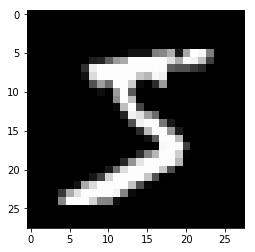

In [14]:
plt.imshow(x_train[0], cmap="gray")